In [1]:
pip install torch torchvision matplotlib

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.0 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 819.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.5 MB 16.5 MB/s eta 0:00:01
   --- ------------------------------------ 1.4/15.5 MB 18.4 MB/s eta 0:00:01
   ------ --------------------------------- 2.5/15.5 MB 20.0 MB/s eta 0:00:01
   --------- ------------------------------ 3.8/15.5 MB 21.9 MB/s eta 0:00:01
   ------------ --------------------------- 5.0/15.5 MB 22.6 MB/s eta 0:00:01
   ---------------- ----------------------- 6.4/15.5 MB 24.2 MB/s eta 0:00:01
   -------------------- ------------------- 7.9/15.5 MB 25.3 MB/s eta 0:00:01
   ----------------------- ---------------- 9.3/15.5 MB 25.8 MB/s eta 0:00:01
   ---------------------------- ----------- 10.9/15.5 MB 28.5 MB/s eta 0:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
streamlit 1.32.0 requires pillow<11,>=7.1.0, but you have pillow 11.0.0 which is incompatible.


In [3]:
pip install --upgrade torch torchvision torchaudio


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------
# CNN Encoder
# ------------------------
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),  # Output stego image
            nn.Sigmoid()
        )

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        stego = self.encoder(x)
        return stego

# ------------------------
# CNN Decoder
# ------------------------
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, stego):
        return self.decoder(stego)

# ------------------------
# Load and preprocess images
# ------------------------
def load_image(path, size=(128, 128)):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)  # Shape: [1, 3, H, W]

# ------------------------
# Display result
# ------------------------
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img.permute(1, 2, 0).detach().numpy())
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# ------------------------
# Main: Hide and Reveal
# ------------------------
if __name__ == "__main__":
    # Load cover and secret image
    cover = load_image("abomasnow.png")
    secret = load_image("abra.png")

    encoder = Encoder()
    decoder = Decoder()

    # Encode
    stego = encoder(cover, secret)

    # Decode
    revealed = decoder(stego)

    # Show results
    show_images([cover[0], secret[0], stego[0], revealed[0]], 
                ["Cover Image", "Secret Image", "Stego Image", "Revealed Secret"])

ModuleNotFoundError: No module named 'torch._prims_common'

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------------------- Encoder & Decoder ---------------------
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, stego):
        return self.decoder(stego)

# --------------------- Dataset Loader ---------------------
class StegoDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)
                       if img.lower().endswith(('.png', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        cover_path = self.images[idx]
        secret_path = random.choice(self.images)

        cover = Image.open(cover_path).convert("RGB")
        secret = Image.open(secret_path).convert("RGB")

        if self.transform:
            cover = self.transform(cover)
            secret = self.transform(secret)

        return cover, secret

# --------------------- Training Function ---------------------
def train(encoder, decoder, dataloader, device, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for cover, secret in dataloader:
            cover = cover.to(device)
            secret = secret.to(device)

            stego = encoder(cover, secret)
            revealed = decoder(stego)

            loss_cover = criterion(stego, cover)
            loss_secret = criterion(revealed, secret)
            loss = loss_cover + loss_secret

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

    torch.save(encoder.state_dict(), "encoder.pth")
    torch.save(decoder.state_dict(), "decoder.pth")
    print("Models saved as encoder.pth and decoder.pth.")

# --------------------- Utility Functions ---------------------
def load_image(path, transform):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)

def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

def test(encoder, decoder, transform, device, cover_path, secret_path):
    cover = load_image(cover_path, transform).to(device)
    secret = load_image(secret_path, transform).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    show_images([cover[0], secret[0], stego[0], revealed[0]],
                ["Cover", "Secret", "Stego", "Revealed"])

# --------------------- Main ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # ====> Set paths properly here:
    train_folder = r"C:\JN\img"           # Folder with multiple training images
    test_cover = r"C:\JN\Image_1.png"          # Test cover image
    test_secret = r"C:\JN\Image_2.png"        # Test secret image

    # Create dataset
    if not os.path.exists(train_folder):
        raise FileNotFoundError(f"Training folder not found: {train_folder}")
    dataset = StegoDataset(train_folder, transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Initialize models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)

    # Train
    train(encoder, decoder, dataloader, device, epochs=10)

    # Reload for testing
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    # Test
    test(encoder, decoder, transform, device, test_cover, test_secret)

ModuleNotFoundError: No module named 'torch._prims_common'

In [5]:
python -c "import torch; print(torch.__version__)"


SyntaxError: invalid syntax (3555061209.py, line 1)

In [6]:
conda activate myenv



Note: you may need to restart the kernel to use updated packages.



CondaError: Run 'conda init' before 'conda activate'



In [7]:
pip uninstall torch -y

Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB 23.1 MB/s eta 0:02:06
   ---------------------------------------- 0.0/2.9 GB 29.2 MB/s eta 0:01:40
   ---------------------------------------- 0.0/2.9 GB 30.7 MB/s eta 0:01:35
   ---------------------------------------- 0.0/2.9 GB 33.4 MB/s eta 0:01:27
   ---------------------------------------- 0.0/2.9 GB 33.3 MB/s eta 0:01:27
   ---------------------------------------- 0.0/2.9 GB 35.3 MB/s eta 0:01:23
   ---------------------------------------- 0.0/2.9 GB 38.5 MB/s eta 0:01:16
   ---------------------------------------- 0.0/2.9 GB 36.3 MB/s eta 0:01:20
   ---------------------------------------- 0.0/2.9 GB 38.5 MB/s eta 0:01:16
   ---------------------------------------- 0.0/2.9 GB 36.4 MB/s eta 0:01:20
   ---------------------------------

Epoch [1/10], Loss: 0.0120
Epoch [2/10], Loss: 0.0048
Epoch [3/10], Loss: 0.0045
Epoch [4/10], Loss: 0.0043
Epoch [5/10], Loss: 0.0040
Epoch [6/10], Loss: 0.0037
Epoch [7/10], Loss: 0.0038
Epoch [8/10], Loss: 0.0035
Epoch [9/10], Loss: 0.0036
Epoch [10/10], Loss: 0.0034
Models saved as encoder.pth and decoder.pth.


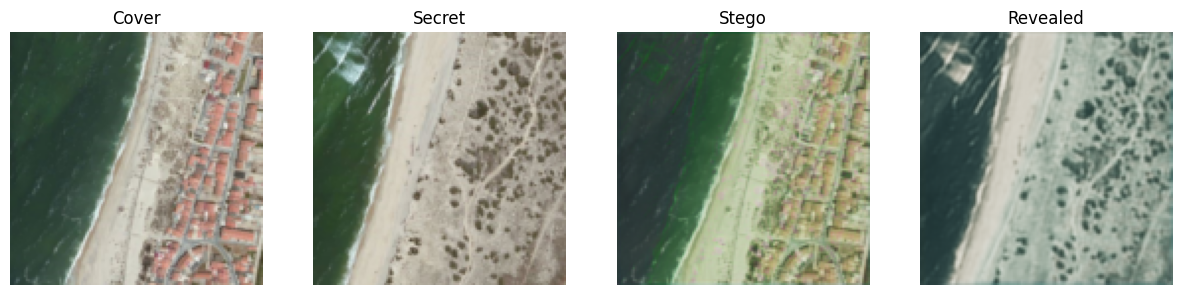

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------------------- Encoder & Decoder ---------------------
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, stego):
        return self.decoder(stego)

# --------------------- Dataset Loader ---------------------
class StegoDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)
                       if img.lower().endswith(('.png', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        cover_path = self.images[idx]
        secret_path = random.choice(self.images)

        cover = Image.open(cover_path).convert("RGB")
        secret = Image.open(secret_path).convert("RGB")

        if self.transform:
            cover = self.transform(cover)
            secret = self.transform(secret)

        return cover, secret

# --------------------- Training Function ---------------------
def train(encoder, decoder, dataloader, device, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for cover, secret in dataloader:
            cover = cover.to(device)
            secret = secret.to(device)

            stego = encoder(cover, secret)
            revealed = decoder(stego)

            loss_cover = criterion(stego, cover)
            loss_secret = criterion(revealed, secret)
            loss = loss_cover + loss_secret

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

    torch.save(encoder.state_dict(), "encoder.pth")
    torch.save(decoder.state_dict(), "decoder.pth")
    print("Models saved as encoder.pth and decoder.pth.")

# --------------------- Utility Functions ---------------------
def load_image(path, transform):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)

def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

def test(encoder, decoder, transform, device, cover_path, secret_path):
    cover = load_image(cover_path, transform).to(device)
    secret = load_image(secret_path, transform).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    show_images([cover[0], secret[0], stego[0], revealed[0]],
                ["Cover", "Secret", "Stego", "Revealed"])

# --------------------- Main ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # ====> Set paths properly here:
    train_folder = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images"           # Folder with multiple training images
    test_cover = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"          # Test cover image
    test_secret = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"        # Test secret image

    # Create dataset
    if not os.path.exists(train_folder):
        raise FileNotFoundError(f"Training folder not found: {train_folder}")
    dataset = StegoDataset(train_folder, transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Initialize models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)

    # Train
    train(encoder, decoder, dataloader, device, epochs=10)

    # Reload for testing
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    # Test
    test(encoder, decoder, transform, device, test_cover, test_secret)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------------- Encoder ---------------- #

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x


# ---------------- Decoder ---------------- #

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, encoded_image):
        x = self.relu(self.conv1(encoded_image))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x


# ---------------- Image Loader ---------------- #

def load_image(path, transform):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)


# ---------------- Main Test ---------------- #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Load models
encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

encoder.eval()
decoder.eval()

# Example transform and image paths
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

cover_path = "cover.png"
secret_path = "secret.png"

cover_image = load_image(cover_path, transform).to(device)
secret_image = load_image(secret_path, transform).to(device)

# Encode
with torch.no_grad():
    encoded_image = encoder(cover_image, secret_image)
    decoded_secret = decoder(encoded_image)

# Convert tensors to numpy images for display
def tensor_to_image(tensor):
    image = tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)
    return image

encoded_image_np = tensor_to_image(encoded_image)
decoded_secret_np = tensor_to_image(decoded_secret)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Cover Image")
plt.imshow(tensor_to_image(cover_image))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Encoded Image")
plt.imshow(encoded_image_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Decoded Secret")
plt.imshow(decoded_secret_np)
plt.axis("off")

plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

encoder.eval()
decoder.eval()


Decoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [8]:
cover_image = load_image(r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png", device)
secret_image = load_image(r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png", device)

with torch.no_grad():
    encoded_image = encoder(cover_image, secret_image)
    decoded_secret = decoder(encoded_image)


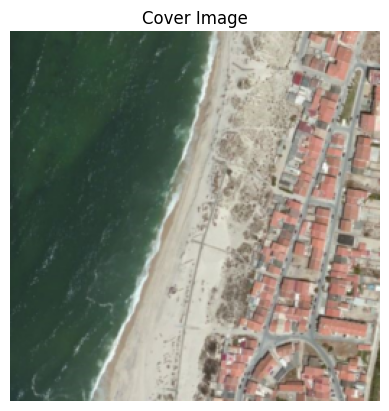

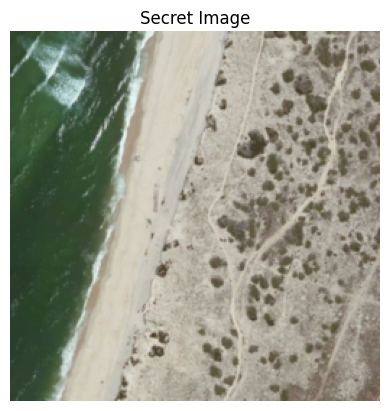

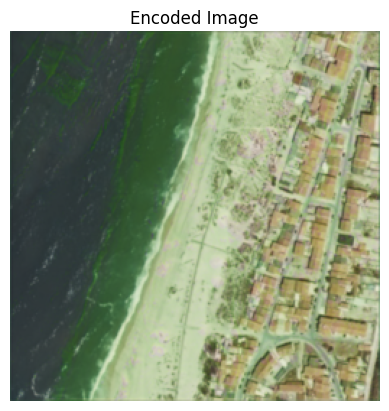

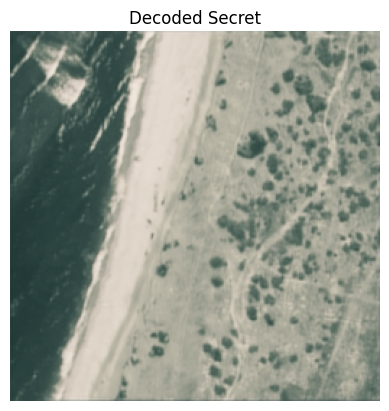

In [9]:
import matplotlib.pyplot as plt

def show_image(tensor, title):
    image = tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(cover_image, "Cover Image")
show_image(secret_image, "Secret Image")
show_image(encoded_image, "Encoded Image")
show_image(decoded_secret, "Decoded Secret")


In [10]:
def show_image(tensor, title):
    image = tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [11]:
def plot_histogram(tensor, title):
    image = tensor.cpu().squeeze(0).numpy()  # shape: [C, H, W]
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(8, 4))

    for i in range(3):
        plt.hist(image[i].flatten(), bins=256, color=colors[i], alpha=0.5, label=f'{colors[i]} channel')

    plt.title(f'Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


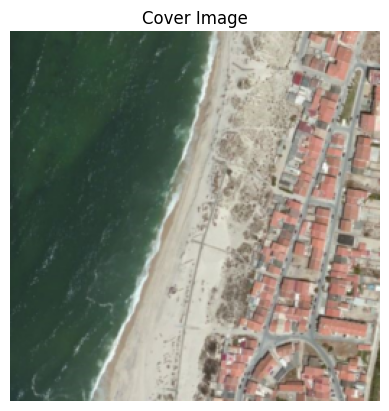

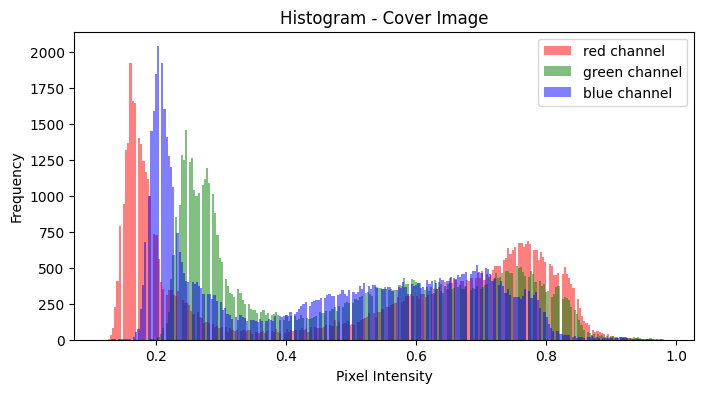

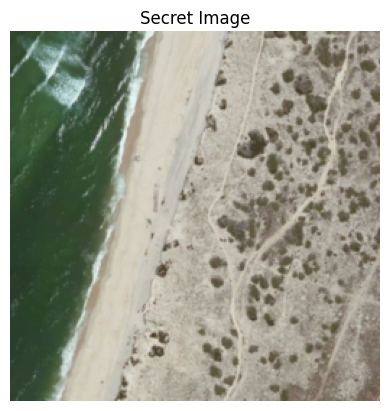

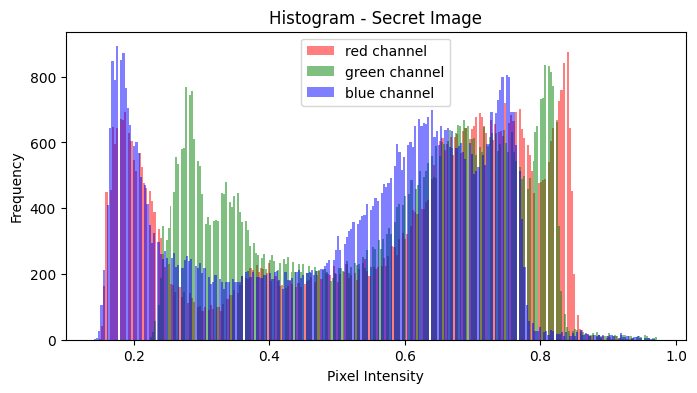

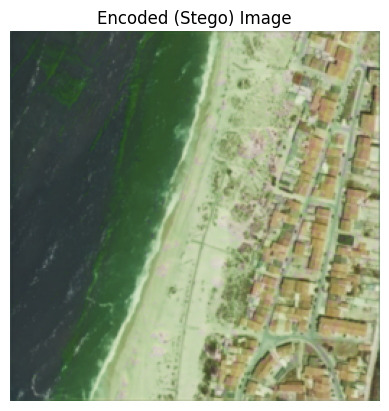

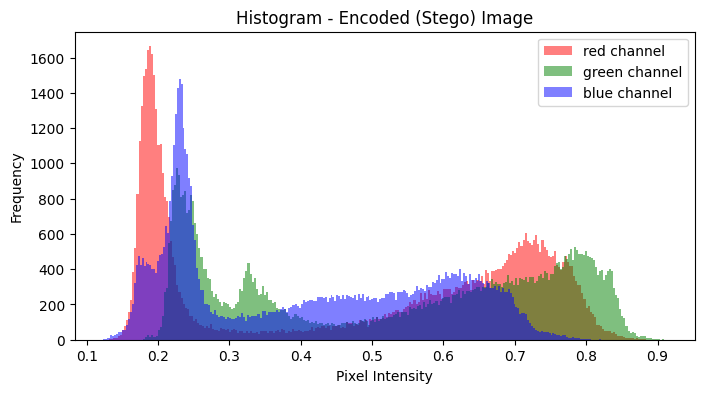

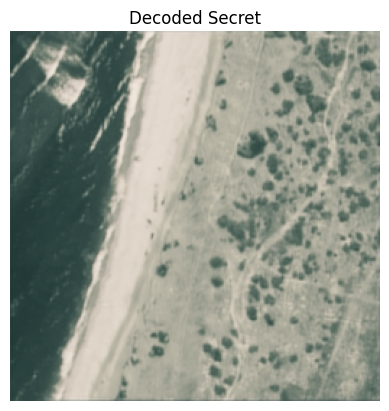

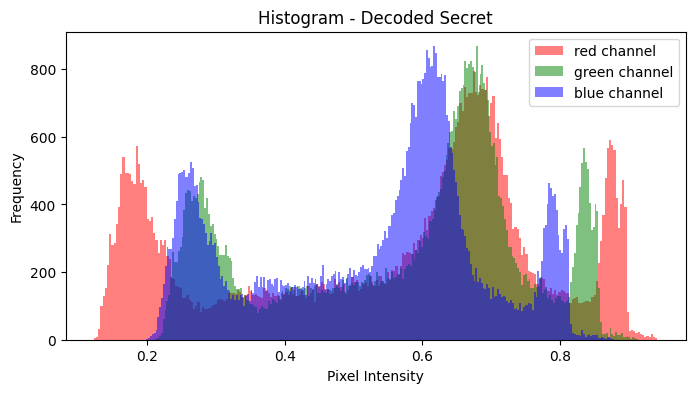

In [12]:
show_image(cover_image, "Cover Image")
plot_histogram(cover_image, "Cover Image")

show_image(secret_image, "Secret Image")
plot_histogram(secret_image, "Secret Image")

show_image(encoded_image, "Encoded (Stego) Image")
plot_histogram(encoded_image, "Encoded (Stego) Image")

show_image(decoded_secret, "Decoded Secret")
plot_histogram(decoded_secret, "Decoded Secret")
